In [13]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset -p /content/mango_leaf_disease --unzip

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 98% 101M/103M [00:00<00:00, 266MB/s] 
100% 103M/103M [00:00<00:00, 254MB/s]


In [14]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, DenseNet121, InceptionV3, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

In [15]:
base_dir = '/content/mango_leaf_disease'

In [16]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

def get_data_generators(target_size):
    train_gen = datagen.flow_from_directory(
        base_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_gen = datagen.flow_from_directory(
        base_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        base_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )
    return train_gen, val_gen, test_gen

In [17]:
def build_model(base_model, train_generator):
    base_model.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, epochs=10):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.2f}")


    sample_image, sample_label = next(test_generator)  # Use `next()` function here
    prediction = model.predict(sample_image)
    predicted_class = np.argmax(prediction[0])
    true_class = np.argmax(sample_label[0])

    print(f"Predicted Class: {predicted_class}, True Class: {true_class}")

    return history, test_accuracy

In [19]:
models = {
    "VGG19": (VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224)),
    "DenseNet121": (DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224)),
    "InceptionV3": (InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299)),
    "Xception": (Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299))
}

histories = {}
test_accuracies = {}

In [20]:
for model_name, (base_model, target_size) in models.items():
    print(f"Training {model_name} model...")
    train_generator, val_generator, test_generator = get_data_generators(target_size)
    model = build_model(base_model, train_generator)
    histories[model_name], test_accuracies[model_name] = train_and_evaluate_model(model, train_generator, val_generator, test_generator)

Training VGG19 model...
Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 524ms/step - accuracy: 0.1347 - loss: 2.5208 - val_accuracy: 0.2000 - val_loss: 2.1283 - learning_rate: 1.0000e-04
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 501ms/step - accuracy: 0.1446 - loss: 2.3411 - val_accuracy: 0.2663 - val_loss: 2.0452 - learning_rate: 1.0000e-04
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 501ms/step - accuracy: 0.1508 - loss: 2.2457 - val_accuracy: 0.3212 - val_loss: 2.0071 - learning_rate: 1.0000e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 516ms/step - accuracy: 0.1662 - loss: 2.1559 - val_accuracy: 0.4162 - val_loss: 1.9784 - learning_rate: 1.0000e-04
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 514ms/step - accuracy: 0.1879 - loss: 2.1360 - val_accuracy: 0.4187 - val_loss: 1.9611 - learning_rate: 1.0000e-04
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step -

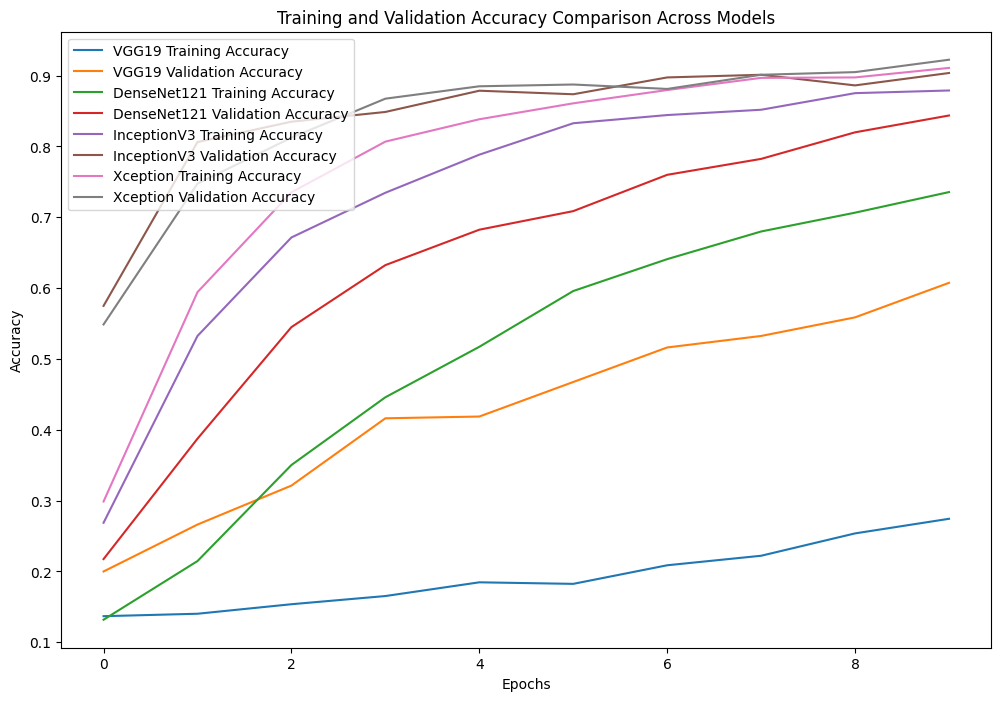

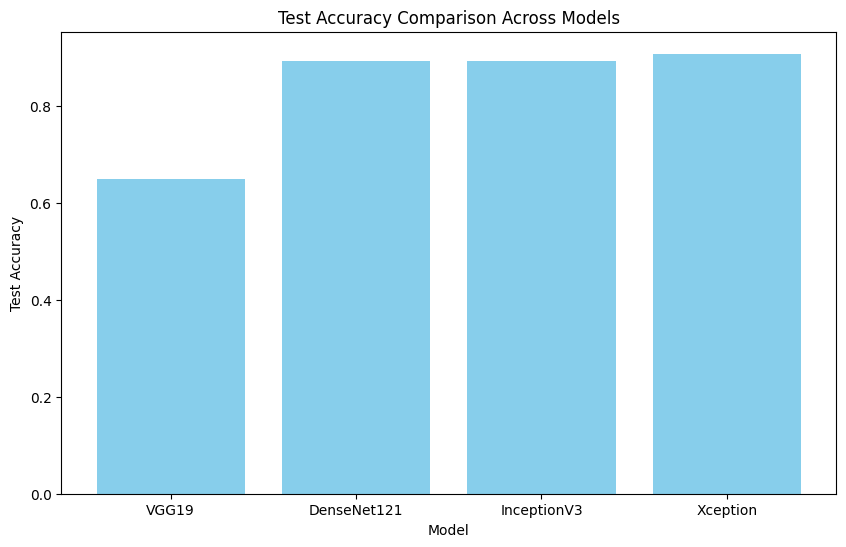

In [21]:
plt.figure(figsize=(12, 8))

for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison Across Models')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison Across Models')
plt.show()